In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%cd LiU/732A81 - Text Mining project
%pwd

/workspace/LiU/732A81 - Text Mining project


'/workspace/LiU/732A81 - Text Mining project'

In [2]:
from datasets import load_dataset
dataset = load_dataset('eurlex')

No config specified, defaulting to: eurlex/eurlex57k
Found cached dataset eurlex (/root/.cache/huggingface/datasets/eurlex/eurlex57k/1.1.0/d2fdeaa4fcb5f41394d2ed0317c8541d7f9be85d2d601b9fa586c8b461bc3a34)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# read eurovoc concepts into pandas dataframe
import pandas as pd
eurovoc_concepts_df = pd.read_json('./data/datasets/EURLEX57K/eurovoc_concepts.jsonl', lines=True)

ValueError: Expected object or value

In [40]:
eurovoc_concepts_df.head()


,id,title
0,1000,financing
1,1005,EU financing
2,1006,compensatory financing
3,1008,financing of aid
4,1015,excise duty


In [6]:
train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['test'])
val = pd.DataFrame(dataset['validation'])
cumulative = pd.concat([train, test, val])

NameError: name 'pd' is not defined

In [6]:
# get the number of documents per class from eurovoc_concepts
labels_count = cumulative.explode('eurovoc_concepts').groupby('eurovoc_concepts').count().reset_index()
labels_count = labels_count[['eurovoc_concepts', 'text']]
labels_count.columns = ['eurovoc_concepts', 'count']
labels_count.head(10)

,eurovoc_concepts,count
0,10,7
1,1000,34
2,1002,2
3,1004,4
4,1005,979
5,1006,23
6,1007,8
7,1008,27
8,1010,5
9,1011,3


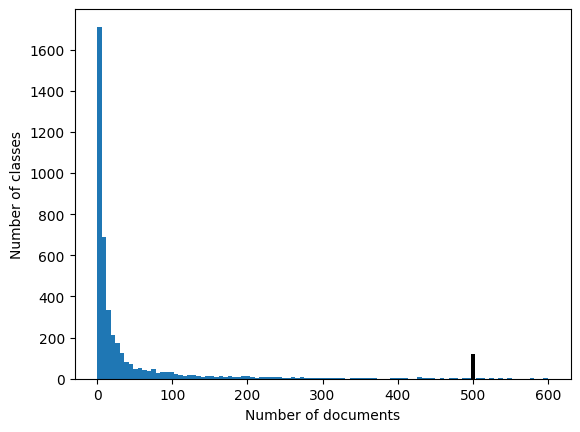

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("whitegrid")

# plot histogram of the number of documents per class
plt.hist(labels_count['count'], bins=100, range=(0, 600))
plt.xlabel('Number of documents')
plt.ylabel('Number of classes')
plt.bar(500, labels_count[labels_count['count'] >= 500].count(), color='black', width=5)
plt.show();

In [8]:
# Number of classes with less than 10 documents
print(f'Number of classes with less than 10 documents: {labels_count[labels_count["count"] < 10].count().values[0]}')

# Number of classes with less than 50 documents
print(f'Number of classes with less than 50 documents: {labels_count[labels_count["count"] < 50].count().values[0]}')


Number of classes with less than 10 documents: 2222
Number of classes with less than 50 documents: 3423


Average number of words per document: 547.5277017543859
Median number of words per document: 399.0
Max number of words per document: 3479
Min number of words per document: 86
Number of documents with more than 500 words: 19886


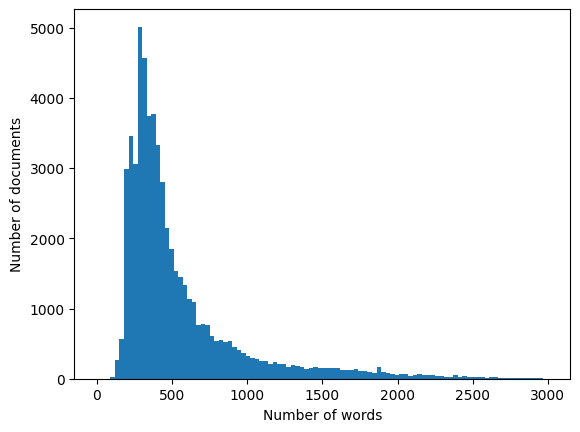

In [9]:
# get the number of words per document
cumulative['num_words'] = cumulative['text'].apply(lambda x: len(x.split()))
print(f'Average number of words per document: {cumulative["num_words"].mean()}')
print(f'Median number of words per document: {cumulative["num_words"].median()}')
print(f'Max number of words per document: {cumulative["num_words"].max()}')
print(f'Min number of words per document: {cumulative["num_words"].min()}')
print(f'Number of documents with more than 500 words: {cumulative[cumulative["num_words"] > 500].count().values[0]}')

# plot histogram of the number of words per document
plt.hist(cumulative['num_words'], bins=100, range=(0, 3000))
plt.xlabel('Number of words')
plt.ylabel('Number of documents')
plt.show();

In [41]:
import spacy
nlp = spacy.load('en_core_web_sm', exclude=['parser', 'ner'])

def preprocess(text):
    # TODO: Replace the next line with your own code.
    doc = nlp(text)
    data = [(token.lemma_) for token in doc if token.is_alpha and not token.is_stop and token.lemma_.isalpha()]
    data = pd.DataFrame(data, columns=['lemma'])
    return list(data.lemma)


# Load Title data from disk

In [3]:
# base model Multinomial Naive Bayes classifier with CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier


# Load the data from disk
import pickle
with open('./data/preprocessed_title/x_train.pkl', 'rb') as f:
    x_train_title = pickle.load(f)
with open('./data/preprocessed_title/x_test.pkl', 'rb') as f:
    x_test_title = pickle.load(f)
with open('./data/preprocessed_title/x_val.pkl', 'rb') as f:
    x_val_title = pickle.load(f)
with open('./data/preprocessed_title/y_train.pkl', 'rb') as f:
    y_train_title = pickle.load(f)
with open('./data/preprocessed_title/y_test.pkl', 'rb') as f:
    y_test_title = pickle.load(f)
with open('./data/preprocessed_title/y_val.pkl', 'rb') as f:
    y_val_title = pickle.load(f)
with open('./data/preprocessed_title/y.pkl', 'rb') as f:
    y = pickle.load(f)
with open('./data/preprocessed_title/eurovoc_concepts_df.pkl', 'rb') as f:
    eurovoc_concepts_df = pickle.load(f)
with open('./data/preprocessed_title/cumulative.pkl', 'rb') as f:
    cumulative = pickle.load(f)


mlb = MultiLabelBinarizer()
y = mlb.fit_transform(cumulative['eurovoc_concepts_limited'])

pipe = Pipeline([('MultinomialNB', MultinomialNB())])

## Vectorize the data with tf-idf

In [4]:
vectorizer = TfidfVectorizer(analyzer=lambda x: x, ngram_range=(1,5))
x_train_title_tfidf = vectorizer.fit_transform(x_train_title).toarray()
x_test_title_tfidf = vectorizer.transform(x_test_title).toarray()
x_val_title_tfidf = vectorizer.transform(x_val_title).toarray()

## Train a multinomial Naive Bayes classifier

In [4]:
import warnings
warnings.filterwarnings('ignore')

clf = MultiOutputClassifier(pipe, n_jobs=-1).fit(x_train_title_tfidf , y_train_title)
y_pred = clf.predict(x_test_title_tfidf)

print(classification_report(y_test_title, y_pred, target_names=mlb.classes_))

              precision    recall  f1-score   support

        1000       0.00      0.00      0.00         5
        1005       0.67      0.02      0.04       107
        1006       0.00      0.00      0.00         5
        1008       0.00      0.00      0.00         1
        1015       0.00      0.00      0.00        10
        1018       0.00      0.00      0.00         2
        1019       0.00      0.00      0.00        45
        1021       0.00      0.00      0.00        12
        1025       0.00      0.00      0.00        23
        1026       0.00      0.00      0.00         9
        1030       0.00      0.00      0.00         5
        1031       1.00      0.62      0.76        34
        1035       0.00      0.00      0.00        16
        1036       0.00      0.00      0.00         2
        1043       0.00      0.00      0.00         2
        1047       0.00      0.00      0.00         2
        1048       1.00      0.57      0.73        28
        1052       0.00    

In [5]:
y_pred_proba = clf.predict_proba(x_test_title_tfidf)


In [6]:
y_pred_proba_vec = np.array(y_pred_proba)
y_pred_proba_vec = np.delete(y_pred_proba_vec, 0, axis=2).squeeze().transpose()
y_pred_proba_vec.shape

NameError: name 'np' is not defined

In [ ]:
y_pred_df = pd.DataFrame(y_pred_proba_vec, columns=mlb.classes_)

In [ ]:
def classify(pred_prob,thresh):
    y_pred = []

    for tag_label_row in pred_prob:
        temp=[]
        for tag_label in tag_label_row:
            if tag_label >= thresh:
                temp.append(1) # Infer tag value as 1 (present)
            else:
                temp.append(0) # Infer tag value as 0 (absent)
        y_pred.append(temp)

    return y_pred

In [ ]:
y_pred_labels = classify(y_pred_proba_vec, 0.5)

In [ ]:
y_pred = np.array(y_pred_labels).ravel() # Flatten
y_true = y_test_title.ravel() 

In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00  12254176
           1       0.85      0.18      0.29     29579

    accuracy                           1.00  12283755
   macro avg       0.92      0.59      0.65  12283755
weighted avg       1.00      1.00      1.00  12283755



In [ ]:
thresholds = np.arange(0.1, 1, 0.05)
f1_scores = []
y_true = y_test_title.ravel() 
for threshold in thresholds:
    y_pred_labels = classify(y_pred_proba_vec, threshold)
    y_pred = np.array(y_pred_labels).ravel() # Flatten
    
    f1_scores.append(classification_report(y_true, y_pred, output_dict=True)['macro avg']['f1-score'])



Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'F1 score')

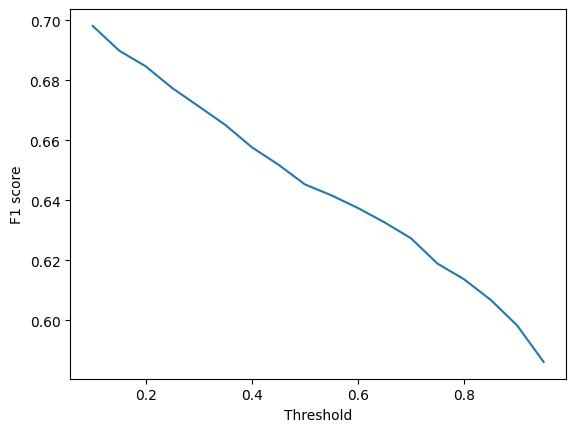

In [ ]:
# plot the F1 score for different thresholds
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.show()

In [85]:
x['macro avg']['f1-score']

0.6453102339591105

# Load Body data from disk

In [5]:
# Load the data from disk
import pickle
with open('./data/preprocessed/x_train.pkl', 'rb') as f:
    x_train_body = pickle.load(f)
with open('./data/preprocessed/x_test.pkl', 'rb') as f:
    x_test_body = pickle.load(f)
with open('./data/preprocessed/x_val.pkl', 'rb') as f:
    x_val_body = pickle.load(f)
with open('./data/preprocessed/y_train.pkl', 'rb') as f:
    y_train_body = pickle.load(f)
with open('./data/preprocessed/y_test.pkl', 'rb') as f:
    y_test_body = pickle.load(f)
with open('./data/preprocessed/y_val.pkl', 'rb') as f:
    y_val_body = pickle.load(f)



## Vectorize the data with tf-idf

In [6]:
x_train_body_tfidf = vectorizer.fit_transform(x_train_body).toarray()
x_test_body_tfidf = vectorizer.transform(x_test_body).toarray()
x_val_body_tfidf = vectorizer.transform(x_val_body).toarray()

## Train a multinomial Naive Bayes classifier

In [7]:
import warnings
warnings.filterwarnings('ignore')

clf = MultiOutputClassifier(pipe, n_jobs=-1).fit(x_train_body_tfidf , y_train_body)
y_pred = clf.predict(x_test_body_tfidf)

print(classification_report(y_test_body, y_pred, target_names=mlb.classes_))

In [ ]:
y_pred_proba = clf.predict_proba(x_test_body_tfidf)
y_pred_proba_vec = np.array(y_pred_proba)
y_pred_proba_vec = np.delete(y_pred_proba_vec, 0, axis=2).squeeze().transpose()
y_pred_proba_vec.shape

y_pred_df = pd.DataFrame(y_pred_proba_vec, columns=mlb.classes_)

def classify(pred_prob,thresh):
    y_pred = []

    for tag_label_row in pred_prob:
        temp=[]
        for tag_label in tag_label_row:
            if tag_label >= thresh:
                temp.append(1) # Infer tag value as 1 (present)
            else:
                temp.append(0) # Infer tag value as 0 (absent)
        y_pred.append(temp)

    return y_pred

y_pred_labels = classify(y_pred_proba_vec, 0.5)
y_pred = np.array(y_pred_labels).ravel() # Flatten
y_true = y_test_body.ravel() 

print(classification_report(y_true,y_pred))

NameError: name 'x_test_body_tfidf' is not defined

In [ ]:
thresholds = np.arange(0.1, 1, 0.05)
f1_scores = []
y_true = y_test_title.ravel() 
for threshold in thresholds:
    y_pred_labels = classify(y_pred_proba_vec, threshold)
    y_pred = np.array(y_pred_labels).ravel() # Flatten
    
    f1_scores.append(classification_report(y_true, y_pred, output_dict=True)['macro avg']['f1-score'])

# plot the F1 score for different thresholds
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.show()